In [ ]:
!pip install keras-tuner -q
!pip install lightgbm==3.2.0 -q

     |████████████████████████████████| 97 kB 3.6 MB/s 
     |████████████████████████████████| 2.0 MB 6.5 MB/s 


### Load dataset

In [ ]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name = 'MEDV')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [ ]:
X_train.shape, X_test.shape

((13209, 8), (4128, 8))

### Use LightGBM GBDT model to do regression without tuning

In [ ]:
def build_model(hp):
    model = lgb.LGBMRegressor(
                        boosting_type='gbdt',
                        # you can also search model type such as: 
                        # boosting_type=hp.Choice("model_type", ['gbdt', 'goss'], default='gbdt'),
                        num_leaves=hp.Int("num_leaves", 5, 50, step=1),
                        learning_rate=hp.Float('learning_rate', 1e-3, 1, sampling='log', default=0.01),
                        n_estimators=hp.Int('n_estimators', 5, 50, step=1)
                        )

    return model

### Customize tuner

In [ ]:

import os
import pickle
import tensorflow as tf
import keras_tuner as kt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

class LightGBMTuner(kt.engine.base_tuner.BaseTuner):

    def run_trial(self, trial, X, y, validation_data):
        model = self.hypermodel.build(trial.hyperparameters) # build the model
        model.fit(X_train, y_train,
                eval_set=[validation_data],
                eval_metric='mse',
                early_stopping_rounds=5) # fit the model
        X_val, y_val = validation_data
        y_pred = model.predict(X_val, num_iteration=model.best_iteration_) # evaluate the model
        eval_mse = mean_squared_error(y_val, y_pred)
        self.oracle.update_trial(trial.trial_id, {'mse': eval_mse})  # inform the oracle of the eval result, the result is a dictionary with the metric names as the keys.
        self.save_model(trial.trial_id, model) # save the model to disk

    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), 'model.txt')
        model.booster_.save_model(fname, num_iteration=model.best_iteration_) 

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), 'model.txt')
        model = lgb.Booster(model_file=fname)
        return model

### Customize Bayesian Optimization search algorithm

In [ ]:
import random

import numpy as np
from scipy import optimize as scipy_optimize
from scipy.stats import norm
from sklearn import exceptions
from sklearn import gaussian_process

from keras_tuner.engine import hyperparameters as hp_module
from keras_tuner.engine import multi_execution_tuner
from keras_tuner.engine import oracle as oracle_module
from keras_tuner.engine import trial as trial_lib


class BayesianOptimizationOracle(oracle_module.Oracle):
    """Bayesian optimization oracle.

    It uses Bayesian optimization with a underlying Gaussian process model.
    The acquisition function used is upper confidence bound (UCB), which can
    be found in the following link:
    https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf

    # Arguments
        objective: String or `kerastuner.Objective`. If a string,
          the direction of the optimization (min or max) will be
          inferred.
        max_trials: Int. Total number of trials
            (model configurations) to test at most.
            Note that the oracle may interrupt the search
            before `max_trial` models have been tested if the search space has been
            exhausted.
        num_initial_points: (Optional) Int. The number of randomly generated samples
            as initial training data for Bayesian optimization. (If not specified,
            a trick is to use the square root of the dimensionality of the 
            hyperparameter space.)
        beta: Float. The balancing factor of exploration and exploitation.
            The larger it is, the more explorative it is.
        seed: Int. Random seed.
        hyperparameters: HyperParameters class instance.
            Can be used to override (or register in advance)
            hyperparamters in the search space.
    """

    def __init__(self,
                 objective,
                 max_trials,
                 beta=2.6,
                 acq_type="ucb",
                 num_initial_points=None,
                 seed=None,
                 hyperparameters=None,
                 *args, **kwargs):
        super(BayesianOptimizationOracle, self).__init__(
            objective=objective,
            max_trials=max_trials,
            hyperparameters=hyperparameters,
            seed=seed,
            *args, **kwargs)
        # Use 2 as the initial number of random points if not presented.
        self.num_initial_points = num_initial_points or 2
        self.beta = beta
        self.seed = seed or random.randint(1, 1e4)
        self._random_state = np.random.RandomState(self.seed)
        self.gpr = self._make_gpr()
        self.acq_type = acq_type

    def _make_gpr(self):
        return gaussian_process.GaussianProcessRegressor(
            kernel=gaussian_process.kernels.Matern(nu=2.5),
            alpha=1e-4,
            normalize_y=True,
            random_state=self.seed)

    def _vectorize_trials(self):
        x, y = [], []
        for trial in self.trials.values():
            # Create a vector representation of each Trial's hyperparameters.
            trial_hps = trial.hyperparameters
            vector = []
            nonfixed_hp_space = [hp for hp in self.hyperparameters.space
                if not isinstance(hp, hp_module.Fixed)]
            for hp in nonfixed_hp_space:
                # For hyperparameters not present in the trial (either added after
                # the trial or inactive in the trial), set to default value.
                if trial_hps.is_active(hp):
                    trial_value = trial_hps.values[hp.name]
                else:
                    trial_value = hp.default

                # Embed an HP value into the continuous space [0, 1].
                prob = hp_module.value_to_cumulative_prob(trial_value, hp)
                vector.append(prob)

            if trial.status == "COMPLETED":
                score = trial.score
                if self.objective.direction == "min":
                    score = -1 * score
            else:
                continue

            x.append(vector)
            y.append(score)

        x = np.array(x)
        y = np.array(y)
        return x, y

    def _vector_to_values(self, vector):
        hps = hp_module.HyperParameters()
        vector_index = 0
        for hp in self.hyperparameters.space:
            hps.merge([hp])
            if isinstance(hp, hp_module.Fixed):
                value = hp.value
            else:
                prob = vector[vector_index]
                vector_index += 1
                value = hp_module.cumulative_prob_to_value(prob, hp)

            if hps.is_active(hp):
                hps.values[hp.name] = value
        return hps.values



    def _random_populate_space(self):
        values = self._random_values()
        if values is None:
            return {'status': trial_lib.TrialStatus.STOPPED,
                    'values': None}
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def _num_completed_trials(self):
        return len([t for t in self.trials.values() if t.status == 'COMPLETED'])

    def populate_space(self, trial_id):

        if self._num_completed_trials() < self.num_initial_points:
            return self._random_populate_space()


        # Update Gaussian process regressor
        x, y = self._vectorize_trials()
        try:
            self.gpr.fit(x, y)
        except exceptions.ConvergenceWarning:
            raise e

        # Three acquisition functions
        def _upper_confidence_bound(x):
            x = x.reshape(1, -1)
            mu, sigma = self.gpr.predict(x, return_std=True)
            return -1 * (mu + self.beta * sigma)

        def _probability_of_improvement(x):
            # calculate the best surrogate score found so far
            x_history, _ = self._vectorize_trials()
            y_pred = self.gpr.predict(x_history, return_std=False)
            y_best = max(y_pred)
            # calculate mean and stdev via surrogate function
            x = x.reshape(1, -1)
            mu, sigma = self.gpr.predict(x, return_std=True)
            # calculate the probability of improvement
            z = (mu - y_best) / (sigma+1E-9)
            prob = norm.cdf(z)
            return -1 * prob

        def _expected_improvement(x):
            # calculate the best surrogate score found so far
            x_history, _ = self._vectorize_trials()
            y_pred = self.gpr.predict(x_history, return_std=False)
            y_best = max(y_pred)
            # calculate mean and stdev via surrogate function
            x = x.reshape(1, -1)
            mu, sigma = self.gpr.predict(x, return_std=True)
            # calculate the probability of improvement
            z = (mu - y_best) / (sigma+1E-9)
            ei = (mu - y_best) * norm.cdf(z) + sigma * norm.pdf(z)
            return -1 * ei

        acq_funcs = { "ucb": _upper_confidence_bound,
            "pi": _probability_of_improvement,
            "ei": _expected_improvement,
        }

        # Sampling based on acquisition functions
        optimal_val = float('inf')
        optimal_x = None
        num_restarts = 50
        bounds = self._get_hp_bounds()
        x_seeds = self._random_state.uniform(bounds[:, 0], bounds[:, 1],
                                             size=(num_restarts, bounds.shape[0]))
        for x_try in x_seeds:
            # Sign of score is flipped when maximizing.
            result = scipy_optimize.minimize(acq_funcs[self.acq_type],
                                             x0=x_try,
                                             bounds=bounds,
                                             method='L-BFGS-B')
            if result.fun[0] < optimal_val:
                optimal_val = result.fun[0]
                optimal_x = result.x

        values = self._vector_to_values(optimal_x)
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def _get_hp_bounds(self):
        nonfixed_hp_space = [hp for hp in self.hyperparameters.space
                if not isinstance(hp, hp_module.Fixed)]
        bounds = []
        for hp in nonfixed_hp_space:
            bounds.append([0, 1])
        return np.array(bounds)
      
    def get_state(self):
        state = super(BayesianOptimizationOracle, self).get_state()
        state.update({
            'num_initial_points': self.num_initial_points,
            'acq_type': self.acq_type,
            'beta': self.beta,
            'seed': self.seed,
        })
        return state

    def set_state(self, state):
        super(BayesianOptimizationOracle, self).set_state(state)
        self.num_initial_points = state['num_initial_points']
        self.acq_type = state['acq_type']
        self.beta = state['beta']
        self.seed = state['seed']
        self._random_state = np.random.RandomState(self.seed)
        self.gpr = self._make_gpr()


### Use customized Bayesian Optimization search algorithm to tune models

In [ ]:
bo_tuner = LightGBMTuner(
        oracle=BayesianOptimizationOracle(
            objective=kt.Objective('mse', 'min'),
            max_trials=100,
            acq_type="ucb", # you can switch between different acquisition functions
            seed=42),
        hypermodel=build_model,
        overwrite=True,
        project_name='bo_tuner')

bo_tuner.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 100 Complete [00h 00m 00s]
mse: 0.23013593082493572

Best mse So Far: 0.22657451402044926
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
from sklearn.metrics import mean_squared_error

best_model = bo_tuner.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.2201682086069178


In [ ]:
bo_tuner.results_summary(1)

Results summary
Results in ./my_lightgbm_tuner
Showing 1 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
num_leaves: 50
learning_rate: 0.21665341881986094
n_estimators: 50
Score: 0.22657451402044926


In [ ]:
bo_tuner = LightGBMTuner(
    oracle=BayesianOptimizationOracle(
        objective=kt.Objective('mse', 'min'),
        max_trials=100,
        seed=42),
    hypermodel=build_model,
    overwrite=False,
    project_name='bo_tuner')

INFO:tensorflow:Reloading Oracle from existing project ./my_lightgbm_tuner/oracle.json
INFO:tensorflow:Reloading Tuner from ./my_lightgbm_tuner/tuner0.json


### Plot search curves

In [ ]:
import matplotlib.pyplot as plt 

def plot_curve(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.show()

def plot_curves(x, ys, xlabel, ylabel, title, ymin, ymax, legend, markers, linestyles, markevery=1):
    for i, y in enumerate(ys):
        plt.plot(x, y, marker=markers[i], linestyle=linestyles[i], markevery=markevery)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.ylim(ymin, ymax)
    plt.legend(legend)
    plt.show()

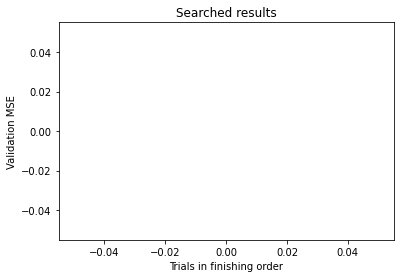

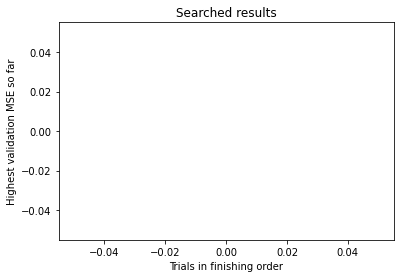

In [ ]:
mse_bo = [bo_tuner.oracle.get_trial(trial_id).score for trial_id in bo_tuner.oracle.end_order]
ids = list(range(len(mse_bo)))
plot_curve(ids, mse_bo, 'Trials in finishing order', 'Validation MSE', 'Searched results')

high_value = float('inf')
high_mse_bo = []
for value in mse_bo:
  high_value = min(high_value, value)
  high_mse_bo.append(high_value)
plot_curve(ids, high_mse_bo, 'Trials in finishing order', 'Highest validation MSE so far', 'Searched results')